# Stable Diffusion 🎨 

<a href=\"https://colab.research.google.com/github/jalammar/ecco/blob/main/notebooks/Ecco_Input_Saliency.ipynb\" target=\"_parent\"><img src=\"https://colab.research.google.com/assets/colab-badge.svg\" alt=\"Open In Colab\"/></a>

This notebook shows an example of how to run `diffusers_interpret.StableDiffusionPipelineExplainer` to explain `diffusers.StableDiffusionPipeline`.

Before going through it, it is recommended to have a look at [🤗 HuggingFace's notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb#scrollTo=-xMJ6LaET6dT).

### 0 - Login in HuggingFace's Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

### 1 - Initialize StableDiffusionPipeline normally

In [ ]:
# make sure you're logged in by running the previous cell or `huggingface-cli login`
import torch
from diffusers import StableDiffusionPipeline
from contextlib import nullcontext

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    
    # FP16 is not working for 'cpu'
    revision='fp16' if device != 'cpu' else None,
    torch_dtype=torch.float16 if device != 'cpu' else None
).to(device)

### 2 - Pass StableDiffusionPipeline to StableDiffusionPipelineExplainer

In [ ]:
from diffusers_interpret import StableDiffusionPipelineExplainer

explainer = StableDiffusionPipelineExplainer(
    pipe,
    
    # We pass `True` in here to be able to have a higher `n_last_diffusion_steps_to_consider_for_attributions` in the cell below
    gradient_checkpointing=True 
)

### 3 - Generate an image with the StableDiffusionPipelineExplainer object

Note that the `explainer()` method accepts all the arguments that `pipe()` accepts. 

We also pass a `generator` argument so that we get a deterministic output.

In [ ]:
prompt = "A cute corgi with the Eiffel Tower in the background"

generator = torch.Generator(device).manual_seed(2023)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=50, 
        generator=generator,
        height=448,
        width=448,
        
        # for this model, the GPU VRAM usage will raise drastically if we increase this argument. feel free to experiment with it
        # if you are not interested in checking the token attributions, you can pass 0 in here
        n_last_diffusion_steps_to_consider_for_attributions=5
    )

#### 3.1 - Check final generated image

In [ ]:
# Final image
output['sample']

#### 3.2 -  Check all the generated images during the diffusion process

In [ ]:
output['all_samples_during_generation'].show(width="100%", height="400px")

You can also check the images individually:

In [ ]:
# Image at first generation 
output['all_samples_during_generation'][0]

In [ ]:
# Image at 33rd generation 
output['all_samples_during_generation'][33]

#### 3.3 - Check the normalized and unnormalized token attributions 

We are now able to see what were the importances of each token in the input text to generate when generating the image.

The token `mars` was the most important feature according to our explainability method.

In [ ]:
# (token, attribution)
output['token_attributions']

In [ ]:
# (token, attribution_percentage)
output['normalized_token_attributions']

### 4 - Get explanations for a specific part of the image

`diffusers-interpret` also computes the tokens importances for generating a particular part of the output image.

In the current implementation, we only need to re-run the `explainer` and pass it the `explanation_2d_bounding_box` argument with the bounding box we are interested in seeing.

In [ ]:
prompt = "A cute corgi with the Eiffel Tower in the background"

generator = torch.Generator(device).manual_seed(2023)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=50, 
        generator=generator,
        height=448,
        width=448,
        
        # for this model, the GPU VRAM usage will raise drastically if we increase this argument. feel free to experiment with it
        # if you are not interested in checking the token attributions, you can pass 0 in here
        n_last_diffusion_steps_to_consider_for_attributions=5,
        
        explanation_2d_bounding_box=((305, 180), (448, 448)), # (upper left corner, bottom right corner)
    )


#### 4.1 - Check generated image

A red bounding box is now visible in the picture, to indicate the area that `explainer` is looking at when calculating the token attributions.

In [ ]:
output['sample']

#### 4.2 - Check token attributions for bounding box

In [ ]:
# (token, attribution_percentage)
output['normalized_token_attributions']

### 5 - Same generation, but with a different `explanation_2d_bounding_box`

In [ ]:
prompt = "A cute corgi with the Eiffel Tower in the background"

generator = torch.Generator(device).manual_seed(2023)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=50, 
        generator=generator,
        height=448,
        width=448,
        
        # for this model, the GPU VRAM usage will raise drastically if we increase this argument. feel free to experiment with it
        # if you are not interested in checking the token attributions, you can pass 0 in here
        n_last_diffusion_steps_to_consider_for_attributions=5,
        
        explanation_2d_bounding_box=((140, 0), (270, 190)), # (upper left corner, bottom right corner)
    )

### 5 - Same generation, but with a different `explanation_2d_bounding_box`

In [14]:
prompt = "A cute corgi with the Eiffel Tower in the background"

generator = torch.Generator(device).manual_seed(2023)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=50, 
        generator=generator,
        height=448,
        width=448,
        
        # for this model, the GPU VRAM usage will raise drastically if we increase this argument. feel free to experiment with it
        # if you are not interested in checking the token attributions, you can pass 0 in here
        n_last_diffusion_steps_to_consider_for_attributions=5,
        
        explanation_2d_bounding_box=((140, 0), (270, 190)), # (upper left corner, bottom right corner)
    )

Diffusion process:   0%|          | 0/51 [00:00<?, ?it/s]

Calculating token attributions... Done!


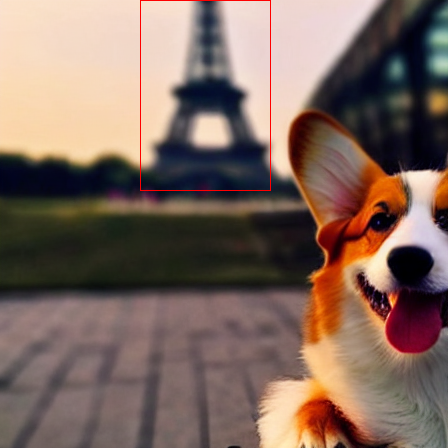

In [15]:
output['sample']

In [16]:
# (token, attribution_percentage)
output['normalized_token_attributions']

[('a', 8.495),
 ('cute', 9.758),
 ('corgi', 20.341),
 ('with', 9.122),
 ('the', 3.377),
 ('eiffel', 16.5),
 ('tower', 22.804),
 ('in', 3.574),
 ('the', 1.219),
 ('background', 4.809)]